<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/PYT_SBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch
from torch_geometric.data import Data
import numpy as np

# List of standard amino acids
AMINO_ACIDS = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
}

# Physicochemical properties dictionary
AA_PROPERTIES = {
    "ALA": [1.24, 0.62, 0.38, 0.05, 6.00, 1.42, 1.00],
    "ARG": [2.74, -2.53, 0.89, 0.93, 10.76, 0.98, 0.79],
    "ASN": [2.14, -0.78, 0.48, 0.54, 5.41, 0.89, 0.76],
    "ASP": [2.16, -0.90, 0.49, 0.52, 2.85, 0.85, 0.72],
    "CYS": [1.50, 0.29, 0.54, 0.79, 5.07, 0.77, 0.63],
    "GLN": [2.17, -0.85, 0.51, 0.70, 5.65, 1.11, 0.92],
    "GLU": [2.18, -0.74, 0.52, 0.67, 3.15, 1.09, 0.90],
    "GLY": [0.00, 0.48, 0.00, 0.00, 6.06, 0.57, 0.57],
    "HIS": [2.48, -0.40, 0.69, 0.95, 7.60, 1.00, 0.87],
    "ILE": [3.08, 1.25, 0.76, 0.90, 6.05, 1.00, 0.97],
    "LEU": [2.80, 1.22, 0.74, 0.92, 6.01, 1.34, 1.01],
    "LYS": [2.90, -2.25, 0.84, 0.93, 9.74, 1.00, 0.79],
    "MET": [2.67, 1.02, 0.72, 1.01, 5.74, 1.20, 0.97],
    "PHE": [2.58, 1.47, 0.78, 1.26, 5.48, 1.16, 0.95],
    "PRO": [1.95, 0.09, 0.64, 0.75, 6.30, 0.57, 0.55],
    "SER": [1.31, -0.28, 0.41, 0.68, 5.68, 0.77, 0.75],
    "THR": [1.50, -0.18, 0.44, 0.69, 5.60, 0.83, 0.78],
    "TRP": [3.07, 1.45, 0.81, 1.41, 5.89, 1.09, 0.92],
    "TYR": [2.67, 0.94, 0.76, 1.20, 5.64, 0.97, 0.90],
    "VAL": [2.50, 1.08, 0.71, 0.91, 6.00, 1.06, 0.93],
}

FEATURE_SIZE = len(next(iter(AA_PROPERTIES.values()))) + 1  # Add B-factor

def parse_pdb_with_sites(pdb_file):
    """
    Parses a PDB file to extract:
    - ATOM lines: Standard protein atoms (non-binding site)
    - SITE lines: Atoms that belong to a binding site
    """
    atom_positions = {}
    site_residues = set()
    residue_b_factors = {}
    residue_names = {}

    with open(pdb_file, "r") as file:
        for line in file:
            if line.startswith(("SITE", "ATOM")):
                try:
                    chain_id = line[21]
                    res_id_str = line[22:26].strip()
                    res_id = int(''.join(filter(str.isdigit, res_id_str)))
                    residue_name = line[17:20].strip()
                    atom_name = line[12:16].strip()
                    x, y, z = map(float, [line[30:38], line[38:46], line[46:54]])
                    b_factor = float(line[60:66].strip())

                    residue_key = (chain_id, res_id)
                    residue_names[residue_key] = residue_name

                    if residue_key not in residue_b_factors:
                        residue_b_factors[residue_key] = []
                    residue_b_factors[residue_key].append(b_factor)

                    if atom_name == "CA":
                        atom_positions[residue_key] = np.array([x, y, z])

                    if line.startswith("SITE"):
                        site_residues.add(residue_key)

                except ValueError:
                    continue

    return atom_positions, site_residues, residue_b_factors, residue_names


def compute_edges(residue_positions, cutoff=8.0):
    """
    Computes edges between residues based on Cα atom distances.
    Returns:
      - `edges`: List of (res1, res2) residue pairs within the cutoff.
      - `edge_features`: Tensor of pairwise distances.
    """
    edges = []
    edge_features = []

    residue_keys = list(residue_positions.keys())
    coords = np.array([residue_positions[rid] for rid in residue_keys])

    # Compute pairwise distance matrix
    dist_matrix = np.linalg.norm(coords[:, None] - coords[None, :], axis=-1)

    # Get pairs of residues within the cutoff distance
    i_idx, j_idx = np.where((dist_matrix <= cutoff) & (dist_matrix > 0))

    for i, j in zip(i_idx, j_idx):
        if i < j:
            edges.append((residue_keys[i], residue_keys[j]))
            edge_features.append([dist_matrix[i, j]])  # Store distance as feature

    return edges, torch.tensor(edge_features, dtype=torch.float)



FEATURE_SIZE = 8  # 7 physicochemical properties + 1 B-factor

def create_protein_graph(pdb_file):
    """
    Creates a PyTorch Geometric graph for a protein with node and edge features.
    """
    atom_positions, site_residues, residue_b_factors, residue_names = parse_pdb_with_sites(pdb_file)
    residue_features = []
    residue_labels = {}

    for res_id in atom_positions.keys():
        residue_name = residue_names.get(res_id, "UNK")
        binding_label = 1 if res_id in site_residues else -1
        residue_labels[res_id] = binding_label

        mean_b_factor = np.mean(residue_b_factors.get(res_id, [0.0]))

        # Get physicochemical properties or use zero vector
        features = AA_PROPERTIES.get(residue_name, [0] * (FEATURE_SIZE - 1))
        features.append(mean_b_factor)

        # Ensure fixed feature size
        if len(features) < FEATURE_SIZE:
            features += [0] * (FEATURE_SIZE - len(features))
        elif len(features) > FEATURE_SIZE:
            features = features[:FEATURE_SIZE]

        residue_features.append(features)

    # Convert labels to tensor
    node_labels = torch.tensor([residue_labels.get(rid, -1) for rid in atom_positions.keys()], dtype=torch.float)

    # **Compute edges and edge features**
    edges, edge_features = compute_edges(atom_positions)

    # Convert to PyG format
    residue_index = {rid: i for i, rid in enumerate(atom_positions.keys())}
    edge_index = torch.tensor([[residue_index[r1], residue_index[r2]] for r1, r2 in edges]).t()
    edge_attr = edge_features  # Edge distances

    # Convert features to tensor
    node_features = torch.tensor(residue_features, dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=node_labels), residue_index, residue_names



In [ ]:
import pandas as pd
from tabulate import tabulate

def print_node_info(protein_graph, residue_index, residue_names, node_idx):
    """
    Pretty prints the feature and connectivity information for a specific node in the protein graph.

    :param protein_graph: PyTorch Geometric Data object
    :param residue_index: Dictionary mapping (chain_id, res_id) -> node index
    :param residue_names: List storing amino acid names indexed by node index
    :param node_idx: Index of the node (residue) to inspect
    """
    # Get feature vector for the node
    node_features = protein_graph.x[node_idx].tolist()

    # Extract residue metadata
    index_to_residue = {v: k for k, v in residue_index.items()}  # Reverse mapping
    chain_id, res_id = index_to_residue[node_idx]  # Get chain & position
    residue_name = residue_names[node_idx]  # Residue name

    # Extract different feature components
    hydrophobicity, polarity, charge = node_features[:3]
    one_hot_encoding = node_features[3:-1]  # All but last (one-hot encoded amino acids)
    binding_site = node_features[-1]  # Last feature is binding site category

    # Get neighbors (connected nodes)
    connected_nodes = protein_graph.edge_index[1][protein_graph.edge_index[0] == node_idx].tolist()

    # Prepare DataFrame for better visualization
    feature_names = ["Hydrophobicity", "Polarity", "Charge"] + AMINO_ACIDS + ["Binding Site Category"]
    feature_values = [hydrophobicity, polarity, charge] + one_hot_encoding + [binding_site]

    df = pd.DataFrame({"Feature": feature_names, "Value": feature_values})

    print(f"\n=== Residue Information for Node {node_idx} ===")
    print(f"Residue: {residue_name}  |  Chain: {chain_id}  |  Position: {res_id}")
    print("\nResidue Properties:\n")
    print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

    print(f"\n🔗 Connected Residues (Neighbors): {connected_nodes}")

# Example Usage
node_index = 5  # Choose a node to inspect
print_node_info(protein_graph, residue_index, residue_names, node_index)




=== Residue Information for Node 5 ===
Residue: ILE  |  Chain: A  |  Position: 6

Residue Properties:

╒════╤═══════════════════════╤═════════╕
│    │ Feature               │   Value │
╞════╪═══════════════════════╪═════════╡
│  0 │ Hydrophobicity        │       1 │
├────┼───────────────────────┼─────────┤
│  1 │ Polarity              │       0 │
├────┼───────────────────────┼─────────┤
│  2 │ Charge                │       0 │
├────┼───────────────────────┼─────────┤
│  3 │ ALA                   │       0 │
├────┼───────────────────────┼─────────┤
│  4 │ ARG                   │       0 │
├────┼───────────────────────┼─────────┤
│  5 │ ASN                   │       0 │
├────┼───────────────────────┼─────────┤
│  6 │ ASP                   │       0 │
├────┼───────────────────────┼─────────┤
│  7 │ CYS                   │       0 │
├────┼───────────────────────┼─────────┤
│  8 │ GLN                   │       0 │
├────┼───────────────────────┼─────────┤
│  9 │ GLU                   │     

In [75]:
#pdb_file = "1uv6.pdb"
#protein_graph, _, _ = create_protein_graph(pdb_file) # Unpack the tuple to get the Data object

from torch_geometric.data import Dataset

class ProteinGraphDataset(Dataset):
    def __init__(self, pdb_files):
        super().__init__()
        self.pdb_files = pdb_files
        self.graphs = []
        self.max_features = FEATURE_SIZE  # Ensure consistency

        for pdb_file in pdb_files:
            try:
                graph = create_protein_graph(pdb_file)[0]  # Extract Data object

                # **Ensure node features match max feature size**
                if graph.x.shape[1] != self.max_features:
                    pad_size = self.max_features - graph.x.shape[1]
                    graph.x = torch.cat([graph.x, torch.zeros(graph.x.shape[0], pad_size)], dim=1)

                self.graphs.append(graph)
                print(f"✅ Successfully processed {pdb_file}")

            except Exception as e:
                print(f"❌ Error processing {pdb_file}: {e}")  # Catch and print errors

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]


# Example usage

import os

# Define the directory where PDB files are stored
pdb_directory = "/content/proteins_extracted/protwithsite"  # Change this to your actual path

# Get all files with .pdb or .ent extension in the folder
pdb_files = [os.path.join(pdb_directory, f) for f in os.listdir(pdb_directory) if f.endswith((".pdb", ".ent"))]

# Create the dataset
dataset = ProteinGraphDataset(pdb_files)

print(f"Successfully loaded {len(dataset)} graphs.")


#print(protein_graph)
#print("Feature Matrix Shape:", protein_graph.x.shape)
#print("Number of Nodes:", protein_graph.x.shape[0])
#print("Number of Edges:", protein_graph.edge_index.shape[1])


✅ Successfully processed /content/proteins_extracted/protwithsite/4gkm_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/5aba_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/4ivc_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/1eby_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2c3i_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/3ge7_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2weg_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/4j28_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/1q8t_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2j78_protwithsite.pdb
✅ Successfully processed /content/proteins_extracted/protwithsite/2yfe_protwithsite.pdb
✅ Successfully processed /conten

In [ ]:
pdb_file = "pdb3lb5.ent"
protein_graph, _, _ = create_protein_graph(pdb_file) # Unpack the tuple to get the Data object

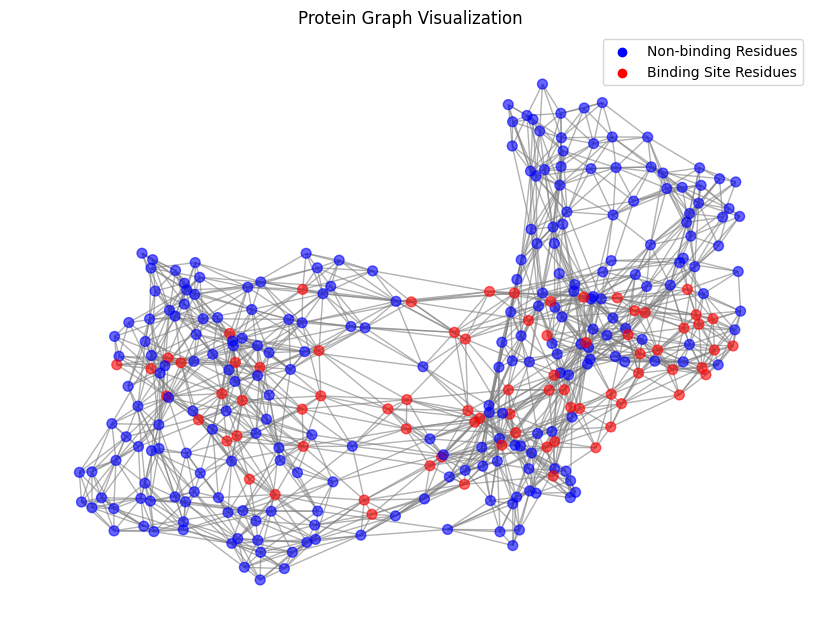

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_protein_graph(protein_graph, title="Protein Graph Visualization"):
    """
    Visualizes the protein graph using NetworkX and Matplotlib.
    Nodes are colored based on binding site labels.
    """
    # Convert PyTorch Geometric graph to NetworkX
    G = to_networkx(protein_graph, to_undirected=True)

    # Get node positions using a force-directed layout
    pos = nx.spring_layout(G, seed=42)

    # Extract binding site information from the node feature matrix
    binding_site_labels = protein_graph.y.numpy()

    # Define node colors:
    # - Non-binding residues (0) are blue
    # - Binding site residues (any other ID) are red
    node_colors = ["red" if label > 0 else "blue" for label in binding_site_labels]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.6)

    # Legend
    plt.scatter([], [], color="blue", label="Non-binding Residues")
    plt.scatter([], [], color="red", label="Binding Site Residues")
    plt.legend(loc="upper right")

    plt.title(title)
    plt.show()

# Call the function to visualize the graph
visualize_protein_graph(protein_graph)


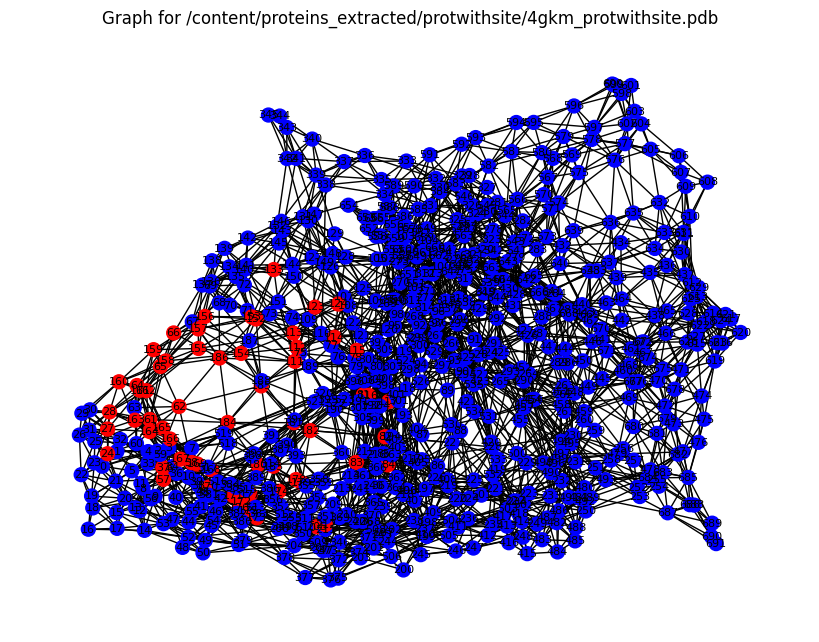

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x79b982edccc0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79b982ea2660> (for post_execute):


KeyboardInterrupt: 

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph, title="Protein Graph"):
    """
    Converts a PyTorch Geometric graph to a networkx graph and plots it.
    Nodes are colored based on their binding site category.
    """
    G = to_networkx(graph, to_undirected=True)  # Convert to networkx
    plt.figure(figsize=(8, 6))

    # Node colors based on binding site category
    node_labels = graph.y.numpy()
    node_colors = ["red" if lbl > 0 else "blue" for lbl in node_labels]  # Binding sites = red

    nx.draw(G, with_labels=True, node_color=node_colors, node_size=100, font_size=8)
    plt.title(title)
    plt.show()

# Visualize the first graph in the dataset
visualize_graph(dataset.get(0), title=f"Graph for {dataset.pdb_files[0]}")

num_graphs = len(dataset)
cols = 3  # Set columns for the grid
rows = (num_graphs // cols) + (num_graphs % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i, graph in enumerate(dataset):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    G = to_networkx(graph, to_undirected=True)
    node_labels = graph.y.numpy()
    node_colors = ["red" if lbl > 0 else "blue" for lbl in node_labels]

    nx.draw(G, ax=ax, node_color=node_colors, node_size=100, font_size=6)
    ax.set_title(f"Graph {i+1}: {dataset.pdb_files[i]}")

# Hide empty subplots if dataset size < rows*cols
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.loader import DataLoader

class BindingSiteGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads=3, num_layers=3):
        super(BindingSiteGNN, self).__init__()

        self.num_layers = num_layers

        # First layer: GAT with edge attributes
        self.conv1 = GATConv(in_channels=in_dim, out_channels=hidden_dim, heads=num_heads, concat=True, edge_dim=1)

        # Intermediate layers: Mix of GAT and GCN
        self.convs = nn.ModuleList()
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim * num_heads, hidden_dim))

        # Last layer: GAT with edge attributes
        self.conv_last = GATConv(hidden_dim, hidden_dim, heads=1, concat=False, edge_dim=1)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim // 2, out_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        x = self.conv_last(x, edge_index, edge_attr)
        x = F.relu(x)

        x = self.fc1(x)
        x = self.dropout(F.relu(x))
        x = self.fc2(x)

        return torch.sigmoid(x)



# Training Function
def train_model(model, train_loader, num_epochs=20, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch.x, batch.edge_index, batch.edge_attr).squeeze()
            loss = criterion(output, (batch.y > 0).float())  # Convert to binary classification
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
    return model


# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            output = model(batch.x, batch.edge_index, batch.edge_attr).squeeze()
            predicted = (output > 0.5).float()
            correct += (predicted == batch.y).sum().item()
            total += batch.y.size(0)
    print(f"Accuracy: {correct / total:.2f}")


# Ensure dataset is loaded before splitting
assert len(dataset) > 0, "Dataset is empty. Check if graphs were loaded correctly."

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create PyTorch Geometric DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Determine input feature size dynamically
protein_graph = dataset[0]  # Get one graph to check feature size
in_dim = protein_graph.x.shape[1]

# Create and train model
model = BindingSiteGNN(in_dim=in_dim, hidden_dim=64, out_dim=1)
# Train the model
trained_model = train_model(model, train_loader)

# Save the trained model weights
torch.save(trained_model.state_dict(), "trained_model.pth")
print("✅ Model saved successfully as 'trained_model.pth'")

# Evaluate model
evaluate_model(trained_model, test_loader)



Epoch 1, Loss: 0.5084
Epoch 2, Loss: 0.4845
Epoch 3, Loss: 0.4818
Epoch 4, Loss: 0.4794
Epoch 5, Loss: 0.4775
Epoch 6, Loss: 0.4799
Epoch 7, Loss: 0.4799
Epoch 8, Loss: 0.4716
Epoch 9, Loss: 0.4711
Epoch 10, Loss: 0.4631
Epoch 11, Loss: 0.4645
Epoch 12, Loss: 0.4593
Epoch 13, Loss: 0.4693
Epoch 14, Loss: 0.4656
Epoch 15, Loss: 0.4606
Epoch 16, Loss: 0.4699
Epoch 17, Loss: 0.4600
Epoch 18, Loss: 0.4568
Epoch 19, Loss: 0.4709
Epoch 20, Loss: 0.4704
✅ Model saved successfully as 'trained_model.pth'
Accuracy: 0.00


In [104]:
import networkx as nx

def predict_binding_sites(model, pdb_file, threshold=0.2):
    model.eval()

    # ✅ Unpack protein graph
    protein_graph, residue_index, residue_names = create_protein_graph(pdb_file)

    # Get predictions
    with torch.no_grad():
        scores = model(protein_graph.x, protein_graph.edge_index, protein_graph.edge_attr).squeeze()

    # ✅ Store residues with binding probability > threshold
    predicted_residues = []
    for i, res_id in enumerate(residue_index.keys()):
        chain, res_num = res_id
        binding_prob = scores[i].item()
        if binding_prob > threshold:
            predicted_residues.append((chain, res_num, binding_prob))

    # ✅ Create a graph to cluster binding residues
    residue_graph = nx.Graph()
    for i, (chain1, res1, _) in enumerate(predicted_residues):
        for j, (chain2, res2, _) in enumerate(predicted_residues):
            if i < j and chain1 == chain2:
                if abs(res1 - res2) <= 5:  # Residues within 5 positions are connected
                    residue_graph.add_edge((chain1, res1), (chain2, res2))

    # ✅ Identify connected binding site clusters
    binding_sites = {}
    site_id = 1
    for component in nx.connected_components(residue_graph):
        binding_sites[site_id] = [(chain, res, score) for (chain, res, score) in predicted_residues if (chain, res) in component]
        site_id += 1

    return binding_sites  # 🔵 Now it returns a dictionary!





In [106]:
pdb_path = "1a3n.pdb"

# Dynamically get input dimension
in_dim = protein_graph.x.shape[1]
model = BindingSiteGNN(in_dim=in_dim, hidden_dim=64, out_dim=1)

# Predict binding sites
predicted_binding_sites = predict_binding_sites(model, pdb_path)

print("Predicted Binding Sites:")
for site_id, residues in predicted_binding_sites.items():
    print(f"Binding Site {site_id}:")
    for chain, res_id, score in residues:
        print(f"  Residue {res_id} in Chain {chain}: Binding Score = {score:.3f}")


Predicted Binding Sites:
Binding Site 1:
  Residue 1 in Chain A: Binding Score = 0.508
  Residue 2 in Chain A: Binding Score = 0.509
  Residue 3 in Chain A: Binding Score = 0.511
  Residue 4 in Chain A: Binding Score = 0.513
  Residue 5 in Chain A: Binding Score = 0.516
  Residue 6 in Chain A: Binding Score = 0.515
  Residue 7 in Chain A: Binding Score = 0.516
  Residue 8 in Chain A: Binding Score = 0.520
  Residue 9 in Chain A: Binding Score = 0.521
  Residue 10 in Chain A: Binding Score = 0.521
  Residue 11 in Chain A: Binding Score = 0.520
  Residue 12 in Chain A: Binding Score = 0.519
  Residue 13 in Chain A: Binding Score = 0.517
  Residue 14 in Chain A: Binding Score = 0.517
  Residue 15 in Chain A: Binding Score = 0.516
  Residue 16 in Chain A: Binding Score = 0.516
  Residue 17 in Chain A: Binding Score = 0.516
  Residue 18 in Chain A: Binding Score = 0.516
  Residue 19 in Chain A: Binding Score = 0.516
  Residue 20 in Chain A: Binding Score = 0.516
  Residue 21 in Chain A: Bin